## Classifying handwritten digits with a CNN


In the previous exercise, we worked with fully-connected neural networks, which are good at handling tabular data, where the inputs and targets are easily presented as vectors.

However, in the case of images, or image-like objects, such models are less efficient for reasons we have discussed in the slides. When inputs are images, or image-like data, a more natural choice of model is a convolution neural network—in particularly, a model which uses 2D convolutional layers.

Before we start worrying about choosing models, let's first acquaint ourselves with the MNIST data.

The first step is to select a directory for the data to live.

In [1]:
mnist_root = "mnist-data/"

If we all set a path this way it will help to maintain consistency throughout this exercise.

### Task 1: Access the MNIST dataset.

PyTorch has a (sort of) sister Python library for dealing with images: [``Torchvision``](https://pytorch.org/vision/stable/index.html) (take a look at the website for a few minutes).

In the previous exercise, we used a custom ``Dataset`` object created specifically for this event, but with ``Torchvision`` come several easy-to-use datasets, one of which is the MNIST digits.

- Look at the arguments of the [MNIST datset](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html): what options do we have?
- Instantiate the (training) dataset.
- Iterate over it: how are the inputs and targets presented to us?
- Plot some images, and set their targets as the title, to make sure the data make sense.

Note: this section might be challenging for many people, so we will go through it together first.

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist-data/
    Split: Train


Input is: <PIL.Image.Image image mode=L size=28x28 at 0x156F5A290>

Target is: 5



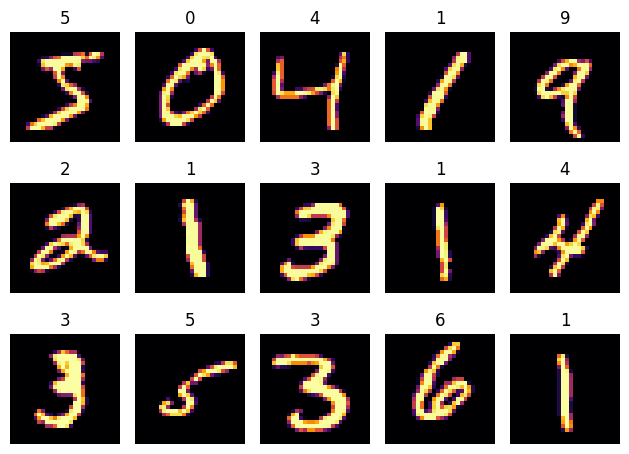

In [2]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

data_set = MNIST(root=mnist_root, download=True)

print(data_set)

img_i, target_i = data_set[0]
print("\n")
print(f"Input is: {img_i}\n")
print(f"Target is: {target_i}\n")

fig, axes = plt.subplots(3, 5)

for i, ax in enumerate(axes.ravel()):
    img_i, target_i = data_set[i]
    ax.imshow(img_i, cmap="inferno")
    ax.set_title(f"{target_i}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()



### Task 2

As before, we have a dataset which gives us inputs and targets, but we still need to convert the data to ``torch.Tensors``

#### Part (a) — raw data to ``Tensor``s

Let's do this basic steps first: supply transforms to map between the raw data and ``torch.Tensors``.



#### Part (b) — fun with data augmentation

Additionally, with image data there are some other consideration we might make:
- Are CNNs rotationally invariant?
  - If we want our model to work on images which are not of a regular orientation, we must use random rotations as a form of augmentation.
- If we train a model on purely black-and-white images, how will it fare on more colourful data?
- Go to ``Torchvision``'s [transforms](https://pytorch.org/vision/stable/transforms.html) and look at the available forms of images augmentation.
  - Take a few minutes to pick ones you think might be relevant.
  - Let's discuss and choose some:
    - `RandomRotation` will prevent rotational invariance as discussed in the lectures.
      - It will be interesting to see how well the net handles the difference between 6 and 9, however.
    - `ColorJitter` applies random variation to the images in terms of hue, saturation, brightness, and contrast. This will enhance feature detection for this dataset.
    - ...

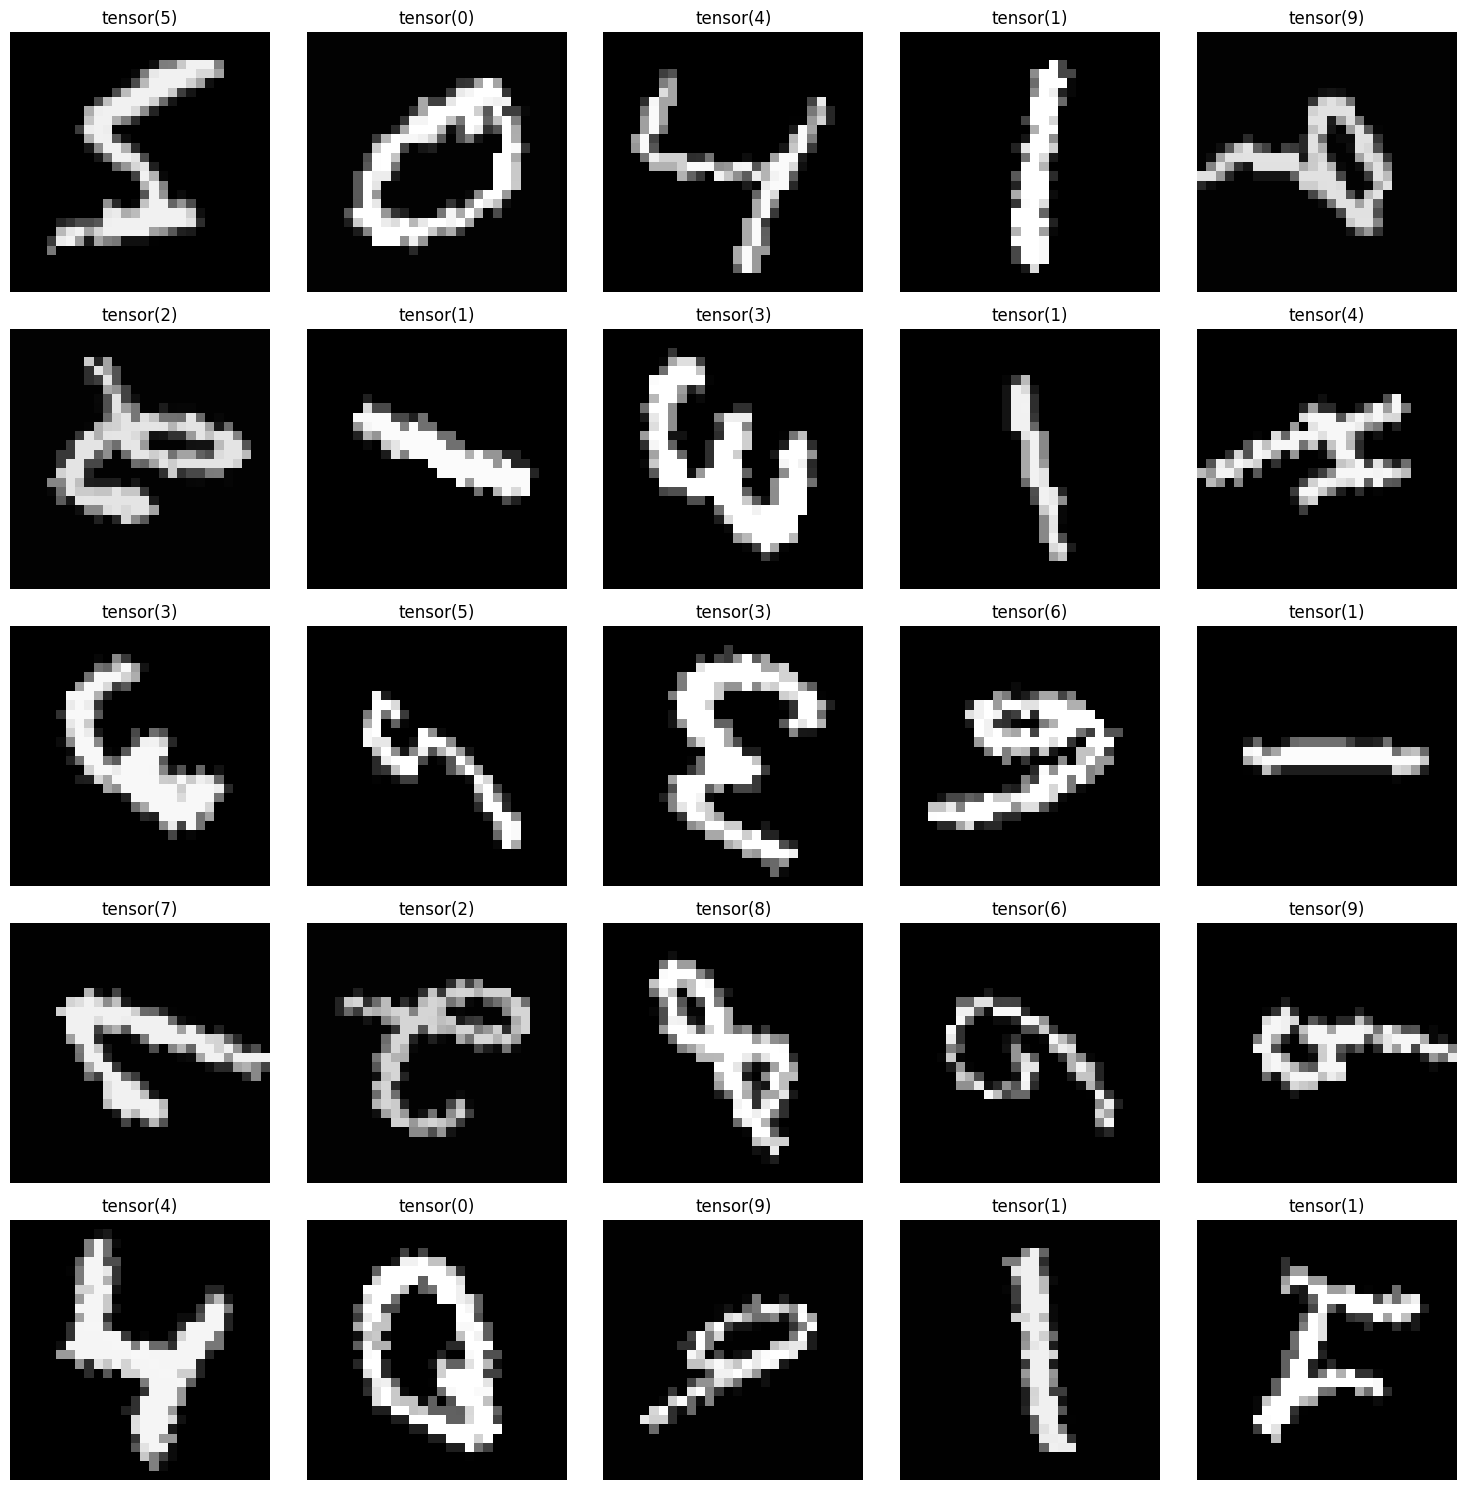

In [3]:
from torchvision.transforms import ToTensor, Compose, RandomRotation, ColorJitter
from torch import Tensor, tensor, float32, eye


def get_img_tfms(training: bool) -> Compose:
    """Return a composition of image transforms.

    Parameters
    ----------
    training : bool
        Are we training? If ``False``, we are validating.

    Returns
    -------
    Compose
        A composition of image transforms.

    """
    # Convert the image from being a 2D tensor to have 3 values for each pixel (RGB).
    # Since the three values are the same it remains the same grayscale image
    tfm_list: List[Callable] = [ToTensor(), lambda x: x.repeat(3, 1, 1)]

    if training is True:
        # tfm_list.append(???)
        tfm_list.append(RandomRotation(180))
        tfm_list.append(
            ColorJitter(brightness=0.1, hue=0.1, saturation=0.1, contrast=0.1)
        )
        pass

    return Compose(tfm_list)


def target_as_tensor(target_idx: int) -> Tensor:
    """Express the target as a ``torch.Tensor``.

    Parameters
    ----------
    target_idx : int
        The ground truth (i.e. the number shown in the image).

    Returns
    -------
    Tensor
        The target as a one-hot-encoded vector.

    """
    return eye(10)[target_idx]


train_set = MNIST(
    mnist_root,
    transform=get_img_tfms(training=True),
    target_transform=target_as_tensor,
    train=True,
)


valid_set = MNIST(
    mnist_root,
    transform=get_img_tfms(training=False),
    target_transform=target_as_tensor,
    train=False,
)

figure, axes = plt.subplots(5, 5, figsize=(15, 15))

for idx, axis in enumerate(axes.ravel()):
    image, target = train_set[idx]

    axis.imshow(image.permute(1, 2, 0), cmap="inferno")
    axis.set_title(target.argmax())
    axis.set_axis_off()

plt.tight_layout()

### Task 3: ``Dataset`` $\to$ ``DataLoader``

As before, wrap the ``Dataset``s in ``DataLoader``s.

In [4]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)

for _, (batch, targets) in zip(range(10), valid_loader):
    print(batch.shape, targets.shape)

torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])
torch.Size([64, 3, 28, 28]) torch.Size([64, 10])


### Task 4: Choose a model architecture

Torchvision provides a collection of models, [here](https://pytorch.org/vision/stable/models.html).

Since we are all using laptops, many of which don't have CUDA-enabled GPUs, we will select a modest neural network than won't melt any of our hardware. Such a network, designed for mobile phones, is [``MOBILENET``](https://pytorch.org/vision/stable/models/mobilenetv3.html).

#### Task 4 (a): instantiate the small version of ``MOBILENET``, and print it out.

Note:
- Torchvision's models can optionally be endowed with pretrained weights (from corresponding models pretrain on the ImageNet dataset).
- We can (optionally) supply these weights.
  - Using weights from a model, trained on one problem, as an initial condition in another problem, is called transfer learning.
  - Why do you think this might be advantageous, even in disparate problems?
    - It will already be trained to recognise some generic/abstract features.
    - ...

In [5]:
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

#### Task 4 (b): overloading the final layer

Uh oh, we've hit a problem.

- Look at the final linear layer.
  - How many output classes are there?
  - How many do we need?
- We need to "overload" the final layer to produce the correct number of output features for our problem. Fortunately this is easy.
- Uncomment the code below, choose the correct number of output features, and print the model again.

In [6]:
from torch.nn import Linear

model.classifier[3] = Linear(model.classifier[3].in_features, 10)

### Task 5: Set up the remaining PyTorch bits and bobs

- We need to choose a loss function appropriate for classification.
  - Can you remember what we chose previously?
- We need an optimiser, too.
  - Remember our friend, Adam?
- Instantiate the model and loss function.

In [7]:
from torch.nn import BCELoss
from torch.optim import Adam

loss_func = BCELoss()
optimiser = Adam(model.parameters(), lr=1e-4)

### Task 6: Set the device

We could have done this when we created the model, but it's fine to do it here.
- If [CUDA](https://pytorch.org/docs/stable/cuda.html) (NVIDIA GPU) is available we will elect to run on that.\n",
- Alternatively, if we are on Apple Silicon we can use the [MPS backend](https://developer.apple.com/metal/pytorch/) for GPU acceleration.
- If neither of these are available we will resort to using the (slower) CPU

In [8]:
from torch.cuda import is_available
from torch.backends import mps

if is_available():
    DEVICE = "cuda"
elif mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(DEVICE)

# Note: here the return/assignment to ``_`` is just to suppress the print.
# The model is moved onto the correct device in-place.
_ = model.to(DEVICE)

mps


### Task 7: Writing our training and validation loops

As before, we need to write our training and validation loops.

- Complete the training loop
- Complete the validation loop

In [9]:
from typing import Dict

from torch import no_grad
from torch.nn import Module

from numpy import mean


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    train_loader : DataLoader
        The ``DataLoader`` for the training set.
    optimiser : Adam
        The optimiser to update the model's parameters with.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.train()
    metrics: Dict[str, float] = {"loss": [], "accuracy": []}

    for batch, targets in train_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        optimiser.zero_grad()

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    valid_loader : DataLoader
        The ``DataLoader`` for the validation set.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.eval()
    metrics: Dict[str, float] = {"loss": [], "accuracy": []}

    for batch, targets in valid_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def batch_level_accuracy(preds: Tensor, targets: Tensor):
    """Compute the batch-level accuracy.

    Parameters
    ----------
    preds : Tensor
        The model's predictions.
    targets : Tensor
        The corresponding labels.

    Returns
    -------
    float
        The batch-level accuracy.

    Notes
    -----
    - This function assumes the ``preds`` have had the softmax applied to them
      along dimension 1, and that the predicted class is therefore
      ``preds.argmax(dim=1)``.

    """
    return (preds.argmax(dim=1) == targets.argmax(dim=1)).float().mean().item()

### Task 8: Training and extracting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turn them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict[str, float]]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.

In [10]:
from time import perf_counter

from pandas import DataFrame

epochs = 5

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start_time = perf_counter()

    train_metrics.append(train_one_epoch(model, train_loader, optimiser, loss_func))

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func))

    stop_time = perf_counter()

    print(f"Epoch {epoch} time: {stop_time - start_time:.3f} seconds.")

print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)

metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")

print(metrics)

Epoch 0 time: 139.890 seconds.
Epoch 1 time: 137.898 seconds.
Epoch 2 time: 135.639 seconds.
Epoch 3 time: 136.681 seconds.
Epoch 4 time: 136.099 seconds.


   loss_train  accuracy_train  loss_valid  accuracy_valid
0    0.265784        0.370114    0.180383        0.603006
1    0.180741        0.600504    0.122150        0.751095
2    0.125428        0.745081    0.079941        0.847731
3    0.091905        0.820904    0.057376        0.894009
4    0.073212        0.860559    0.048015        0.910828


### Task 9: Plotting metrics

Let's plot the training and validation metrics together

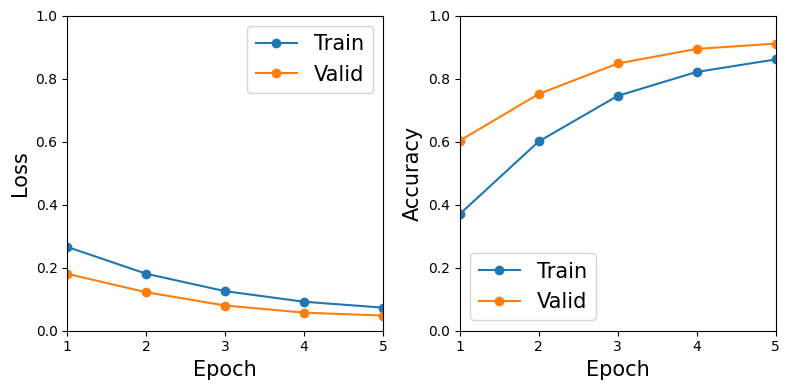

In [11]:
import matplotlib.pyplot as plt
from numpy import linspace


quantities = ["loss", "accuracy"]
splits = ["train", "valid"]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for axis, quant in zip(axes.ravel(), quantities):
    for split in splits:
        key = f"{quant}_{split}"
        axis.plot(
            linspace(1, epochs, epochs),
            metrics[key],
            "-o",
            label=split.capitalize(),
        )
    axis.set_ylabel(quant.capitalize(), fontsize=15)

for axis in axes.ravel():
    axis.legend(fontsize=15)
    axis.set_ylim(bottom=0.0, top=1.0)
    axis.set_xlim(left=1, right=epochs)
    axis.set_xlabel("Epoch", fontsize=15)

fig.tight_layout()

### Task 10: Visualising some predictions

Let's pick some random validation items, predict on them, and visualise the results.

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


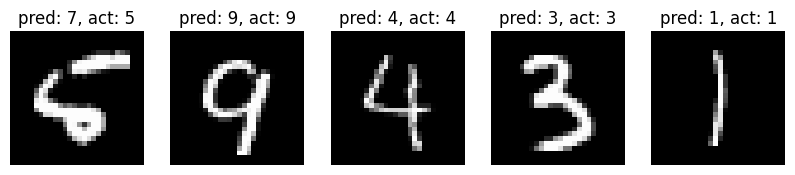

In [12]:
valid_inds = [0, 666, 1024, 2048, 5555]
valid_inds = [8, 16, 24, 32, 40]

# Stick the model on the cpu
_ = model.to("cpu")
_ = model.eval()

figure, axes = plt.subplots(1, len(valid_inds), figsize=(2 * len(valid_inds), 2))

for idx, axis in zip(valid_inds, axes.ravel()):
    img_tensor, target = valid_set[idx]

    with no_grad():
        pred = model(img_tensor.unsqueeze(0)).softmax(dim=1).argmax(dim=1).item()

    axis.imshow(img_tensor.permute(1, 2, 0))
    axis.set_axis_off()
    axis.set_title(f"pred: {pred}, act: {target.argmax()}")